### Exercise Sheet 3

#### 3.2 Learning the Solution Operator
Use TorchPhysics and DeepONets to solve the ODE with time dependent $D(t)$:

\begin{align*}
    \partial_t^2 u(t) &= D(t)(\partial_t u(t))^2 - g \\
    u(0) &= H \\
    \partial_t u(0) &= 0
\end{align*}

If you are using Google Colab, you first have to install TorchPhysics with the following cell. We recommend first enabling the GPU and then running the cell. Since the installation can take around 2 minutes and has to be redone if you switch to the GPU later.

In [1]:
!pip install torchphysics

In [2]:
import torch
import torchphysics as tp
import pytorch_lightning as pl

# Here all parameters are defined:
t_min, t_max = 0.0, 3.0
g, H = 9.81, 50.0
D_min, D_max = 0.005, 5.0
# Size of the data set
data_batch = 12000

# Number of time points for discretization of D and training
N_t = 60

# Training parameters
train_iterations = 10000
learning_rate = 5.e-4

In [3]:
### Function that uses backward Euler to create the dataset (you dont have to understand this cell):
def data_create_fn(N_t, data_batch, start_height):
    # Time grid (Trunk input)
    t = torch.linspace(0, 3.0, 60)
    dt = t[1] - t[0]
    # Tensors for Branch input and expected output
    D_fn = torch.zeros((data_batch, len(t), 1))
    u = torch.zeros((data_batch, len(t), 1))
    v = torch.zeros((data_batch, len(t), 1))
    
    # Create different fuction types for D_fn:
    # First batch are step functions:
    ind = int(data_batch / 3.0)
    random_steps = D_min + (D_max - D_min) * torch.rand((ind, 6, 1))
    D_fn[:ind, :] = random_steps.repeat_interleave(int(N_t/6), dim=1)
    # Second batch are sinus functions:
    random_fre_amp = D_min + (D_max - D_min) * torch.rand((ind, 1, 2))
    random_fre_amp = random_fre_amp.repeat_interleave(N_t, dim=1)
    sin_fn = random_fre_amp[:, :, 1]/2.0 * (D_min + 1 + torch.sin(random_fre_amp[:, :, 0] * t))
    D_fn[ind:2*ind, :] = sin_fn.unsqueeze(-1)
    # Last batch is exp functions:
    missing_idx = data_batch - 2*ind
    random_start_sloope = (D_max - D_min) * torch.rand((missing_idx, 1, 2))
    random_start_sloope = random_start_sloope.repeat_interleave(N_t, dim=1)
    exp_fn = D_min + random_start_sloope[:, :, 1] * torch.exp(-random_start_sloope[:, :, 0] * t)
    D_fn[2*ind:, :] = exp_fn.unsqueeze(-1)
    # flip some exp functions around t=1.5:
    D_fn[int(2*ind + missing_idx/2.0):, :] = torch.flip(D_fn[int(2*ind + missing_idx/2.0):, :, :], dims=(1,))
    
    # Do time stepping to compute solution
    u[:, 0] = start_height
    for i in range(len(t)-1):
        v[:, i+1] = 1/(2*dt*D_fn[:, i+1]) - torch.sqrt(1/(2*dt*D_fn[:, i+1])**2 - (v[:, i] - dt*g)/(dt*D_fn[:, i+1]))
        u[:, i+1] = u[:, i] + dt * v[:, i+1]

    return t.reshape(-1, 1), u, D_fn[:, ::2, :]

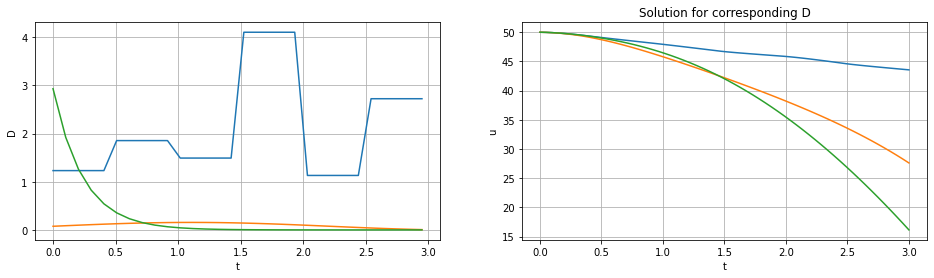

In [4]:
### Here we create the data
t_tensor, u_tensor, D_tensor = data_create_fn(N_t, data_batch, H)

### Show an example plot
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(t_tensor[::2], D_tensor[0])
plt.plot(t_tensor[::2], D_tensor[4000])
plt.plot(t_tensor[::2], D_tensor[8000])
plt.ylabel("D")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(t_tensor, u_tensor[0])
plt.plot(t_tensor, u_tensor[4000])
plt.plot(t_tensor, u_tensor[8000])
plt.ylabel("u")
plt.xlabel("t")
plt.title("Solution for corresponding D")
plt.grid()

#### a) Shuffle and Split Data 
The above data is created in ordered way (e.g. first 4000 entries belong to step functions). Randomly permute the tensors of $u$ and $D$ along the batch dimension and then split both tensors into a training set consisting of 80% of the data and a testing set with the remaining 20%.

**Hint**: for the shuffling `torch.randperm` may be useful.

In [5]:
### TODO: Permute data of u, D along the batch dimension and split them into two sets (training and testing)

# Permute 
permutation = torch.randperm(len(D_tensor))
u_tensor = u_tensor[permutation]
D_tensor = D_tensor[permutation]

# Then split
u_tensor_train = u_tensor[:10000]
D_tensor_train = D_tensor[:10000]
u_tensor_test = u_tensor[10000:]
D_tensor_test = D_tensor[10000:]

Now we start with the TorchPhysics part

##### b) Define Spaces, the Domain and the Sampler for discretization
The spaces and domain are similiar to before. One also needs an output space for the functions $D(t)$ and then create a 
function space that defines that functions from $[0, 3.0] \to \R$ are considered.

Later the BranchNet needs a sampler for discretization of the input functions (even if our training set is already discrete, in the case one later evaluates with a non discrete function).
The sampler should return **every second value** of the time points in `t_tensor`. For this the `tp.samplers.DataSampler` can be used. 

In [6]:
# Spaces 
T = tp.spaces.R1('t') # input variable
U = tp.spaces.R1('u') # output variable
D = tp.spaces.R1('D') # function output space name

# Domain
int_x = tp.domains.Interval(T, t_min, t_max)

# Space that collects the Branch functions
Fn_space = tp.spaces.FunctionSpace(int_x, D)
discretization_sampler = tp.samplers.DataSampler(tp.spaces.Points(t_tensor[::2], T))

##### c) Construct the DeepONet
Build a DeepONet consisting of a fully connected TrunkNet and BranchNet. Check the `TorchPhysics` [documentation](https://torchphysics.readthedocs.io/en/latest/api/torchphysics.models.deeponet.html), to see how this has to implemented. 

Both (TrunkNet and BranchNet) should have 3 hidden layers with 25 neurons each. The output of both networks should be 30 neurons.

In [7]:
### TODO: Build the DeepONet
output_neurons = 30
branch_net = tp.models.FCBranchNet(Fn_space, discretization_sampler, (25,25,25))
trunk_net  = tp.models.FCTrunkNet(T, (25,25,25))
deepOnet   = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons)

In [8]:
### Create data loader to fit DeepONet to the given data.
branch_batch_size = len(u_tensor_train)
trunk_batch_size  = len(t_tensor)
dataloader = tp.utils.DeepONetDataLoader(D_tensor_train, t_tensor, u_tensor_train, D, T, U,
                                         branch_batch_size, trunk_batch_size)

In [9]:
data_condition = tp.conditions.DeepONetDataCondition(deepOnet, dataloader, 2, root=2)

In [10]:
### Start training
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate) 
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=train_iterations, 
                     logger=False, 
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.0 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserW

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [11]:
### Check error on test set:
u_model = deepOnet(tp.spaces.Points(t_tensor, T), D_tensor_test).as_tensor
error = torch.abs(u_model - u_tensor_test)
print("Max. absolute error on test set is:", torch.max(error).item())
print("Relative error is:", torch.max(error).item() / 50.0)

Max. absolute error on test set is: 1.4154281616210938
Relative error is: 0.028308563232421875


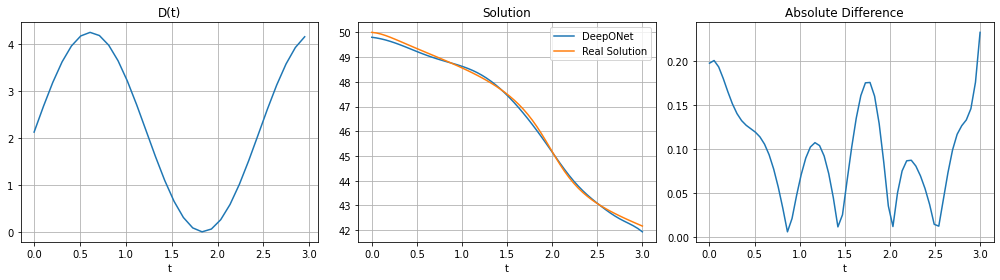

In [12]:
### Plot a solution from the test set:
plot_idx = 321 # <- can you change!

u_model = deepOnet(tp.spaces.Points(t_tensor, T), D_tensor_test[plot_idx]).as_tensor[0]
ref_solution = u_tensor_test[plot_idx]

plt.figure(0, figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(t_tensor[::2], D_tensor_test[plot_idx])
plt.title("D(t)")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(t_tensor, u_model.detach())
plt.plot(t_tensor, ref_solution)
plt.title("Solution")
plt.legend(["DeepONet", "Real Solution"])
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(t_tensor, torch.abs(ref_solution - u_model.detach()))
plt.title("Absolute Difference")
plt.xlabel("t")
plt.grid()
plt.tight_layout()

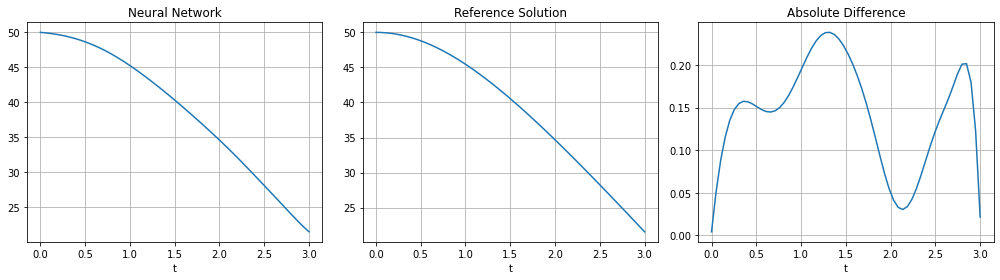

In [13]:
### Now a test for constant values of D:
test_D = 0.05

def analytic_solution(t, D):
    return 1/D * (-torch.log((1+torch.exp(-2*torch.sqrt(D*g)*t))/2) - torch.sqrt(D*g)*t) + H

# Evaluate model:
u_model = deepOnet(tp.spaces.Points(t_tensor, T), lambda t: test_D*torch.ones_like(t)).as_tensor[0]
ref_solution = analytic_solution(t_tensor, torch.tensor(test_D))
                                 
# Plot
plt.figure(0, figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(t_tensor, u_model.detach())
plt.title("Neural Network")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(t_tensor, ref_solution)
plt.title("Reference Solution")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(t_tensor, torch.abs(ref_solution - u_model.detach()))
plt.title("Absolute Difference")
plt.xlabel("t")
plt.grid()
plt.tight_layout()

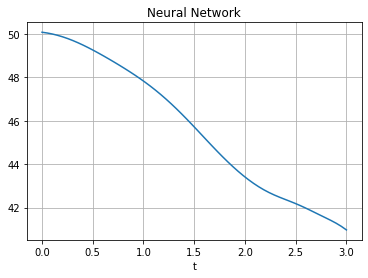

In [14]:
### Lastly, we can also evaluate the network with a custom non discrete function:
def test_fn(t):
    return 1.1 + torch.sin(3.5*t)

u_model = deepOnet(tp.spaces.Points(t_tensor, T), test_fn).as_tensor[0]
plt.plot(t_tensor, u_model.detach())
plt.title("Neural Network")
plt.xlabel("t")
plt.grid()

Instead of using the DeepONet architecture, we could also try to learn the solution operator with a simple 
fully connected neural network. E.g have network with input $(t, D(t_1), \dots, D(t_N))$ and output $u(t; D)$.

This is implemented in the following cell and a comparision is shown in the last cell.

In [16]:
### Compare with simple FCN:
D_vec = tp.spaces.Rn('D', 30)

fcn_model = tp.models.FCN(T*D_vec, U, hidden=(42, 42, 42))

# permute data and create condition:
complete_data = torch.zeros((len(D_tensor_train), 60, 31))
complete_data[:, :, :1] = t_tensor
complete_data[:, :, 1:] = D_tensor_train.squeeze(-1).unsqueeze(1)

in_data_points = tp.spaces.Points(complete_data, T*D_vec)
out_data_points = tp.spaces.Points(u_tensor_train, U)

data_loader = tp.utils.PointsDataLoader((in_data_points, out_data_points), batch_size=len(in_data_points))
data_condition_fcn = tp.conditions.DataCondition(module=fcn_model,
                                             dataloader=data_loader,
                                             norm=2, use_full_dataset=True)

# start training
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver(train_conditions=[data_condition_fcn], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=train_iterations, 
                     logger=False, 
                     enable_checkpointing=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.0 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

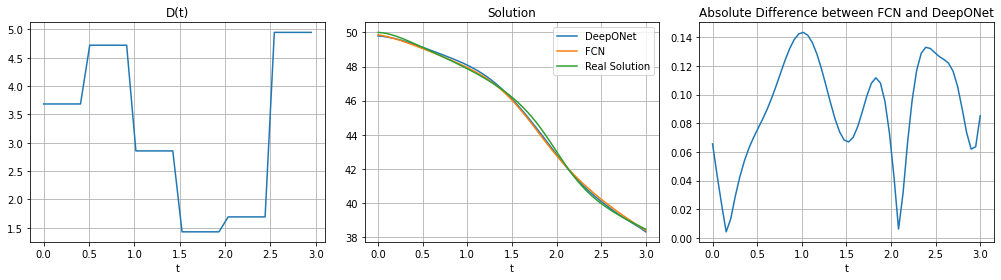

In [20]:
### Plot a solution from the test set:
plot_idx = 921 # <- can you change!

fcn_input = torch.zeros((1, 60, 31))
fcn_input[:, :, :1] = t_tensor
fcn_input[:, :, 1:] = D_tensor_test[plot_idx].squeeze(-1).unsqueeze(0)

fcn_model_out = fcn_model(tp.spaces.Points(fcn_input, T*D_vec)).as_tensor.detach()[0]
u_model = deepOnet(tp.spaces.Points(t_tensor, T), D_tensor_test[plot_idx]).as_tensor[0]
ref_solution = u_tensor_test[plot_idx]

plt.figure(0, figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(t_tensor[::2], complete_data[plot_idx, 0, 1:])
plt.title("D(t)")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(t_tensor, u_model.detach())
plt.plot(t_tensor, fcn_model_out, linestyle="--")
plt.plot(t_tensor, ref_solution)
plt.title("Solution")
plt.legend(["DeepONet", "FCN", "Real Solution"])
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(t_tensor, torch.abs(fcn_model_out- u_model.detach()))
plt.title("Absolute Difference between FCN and DeepONet")
plt.xlabel("t")
plt.grid()
plt.tight_layout()